# 0 BUSINESS UNDERSTANDING

## Motivação
### Qual o contexto?
O CFO requisitou essa solução em uma reunião de resultados mensais aos gerentes
## Causa raiz do problema
### Por que fazer uma previsão de venda?
Investimento em reformas nas lojas
## Dono do problema
### Quem será o stakeholder?
CFO / alguem que conheça o problema
## Formato da solução
### Qual formato da solução ?
* Granularidade - previsão em R$ nas proximas 6 semanas
* Tipo do problema - previsão de venda / demanda
* Potenciais métodos - time series - regressao - redes neurais - deep learning
* Formato da entrega - previsão das vendas nas proximas 6 semana via celular

## Data fields

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 0.0 IMPORTS

In [1]:
import math
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb
import inflection

from scipy                 import stats
from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor, RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [139]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'Kfold number {k}') 
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # treining and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )

        #store performance each kfold iteraction
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({ 'MODEL': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values

    # numero de observacoes - elementos
    n = cm.sum()
    
    # numero de colunas e linhas
    r, k = cm.shape
    
     # resultado do teste de chi2
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1)  )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    #Crammer V é a medida entre a associação de duas variáveis categoricas
    #O V de Cramér é calculado tomando a raiz quadrada da estatística qui-quadrada dividida pelo tamanho da amostra e a dimensão mínima menos 1
    # O resultado vai de 0 a 1 da menor correlação para a maior respectivamente
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [4]:
df_sales_row = pd.read_csv("./data/train.csv", low_memory=False )
df_store_row = pd.read_csv("./data/store.csv", low_memory=False )

#merge
df_row = pd.merge(df_sales_row, df_store_row, how="left", on="Store")

In [5]:
df_row.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
481329,435,6,2014-04-26,2118,238,1,0,0,0,a,a,910.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 PASSO 1: DESCRIÇÃO DOS DADOS


## Analise Descritiva

## 1.1 Rename columns

In [6]:
df1 = df_row.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snackcase = lambda x: inflection.underscore(x)

cols_new = list(map(snackcase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimmensions


In [9]:
print(f'Numero de linhas: {df1.shape[0]}')
print(f'Numero de colunas: {df1.shape[1]}')

Numero de linhas: 1017209
Numero de colunas: 18


## 1.3 Data types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

## Formas de trabalhar com N/A
1 Exclusão: 
    * vantagem: rapido
    * desvantagem: perde informação
2 Machine learning 
    * substituição baseado no comportamento da coluna (media/ mediana/ clusterização)
3 Pensando no negócio
    * Como gerou este N/A? 
    

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
169459,1095,1,2015-03-02,6851,807,1,1,0,0,a,a,690.0,6.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [13]:
#competition_distance 
## Se esta coluna esta NA pode ser que a distancia entre o concorrente é muito grande, não sendo reconhecida dentro do sistema como um concorrente.
## Para substituir este dado usaremos o um valor maior que a maior distancia presente nos dados, o que significa que não tem um competidor proximo 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(5).T

,675685,423110,140935,913466,824705
store,781,196,446,1067,391
day_of_week,7,2,5,4,6
date,2013-11-03 00:00:00,2014-06-17 00:00:00,2015-03-27 00:00:00,2013-04-04 00:00:00,2013-06-22 00:00:00
sales,0,5931,4221,4964,2522
customers,0,731,577,418,363
open,0,1,1,1,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,a,c,a,d,a


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Data types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [19]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
16561,952,5,7385,596,1,1,0,6300.0,10,2013,0,29,2015,0
758966,437,2,5940,755,1,0,1,430.0,8,2013,1,50,2010,0


In [20]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
300472,0,a,a,0,Oct
362650,0,a,a,0,Aug


### 1.7.1 Numerical Attributes

In [21]:
#Central Tendency - mean, median
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion desvio padrão std, min, max, range, skew, kurtosis
dispersion_min = pd.DataFrame(num_attributes.apply(min)).T
dispersion_max = pd.DataFrame(num_attributes.apply(max)).T
dispersion_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# Identificação da normalidade...
# Skew (Assimetria) é uma medida de distirção, se o skew não for próximo a zero os dados não estão distribuidos dormalmente
# Se a assimetria é menor que -1 ou maior que 1, a distribuição é altamente distorcida.
# Se a assimetria é entre -1 e -0,5 ou entre 0,5 e 1, a distribuição é enviesada moderadamente.
# Se a assimetria é entre -0,5 e 0,5, a distribuição é aproximadamente simétrica.
dispersion_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew() - x.min())).T

# A curtose informa a altura e a nitidez do pico central, em relação a uma curva de sino padrão. -3 para distribuição normal.
dispersion_kurt = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() - x.min())).T

# O desvio padrão mede a disperção em torno da média, útil para medir a disperção dentro do conjunto de dados
# ex: media 500 com desvio de 200, significa que dentro dos dados o valor minimo é 300 e o máximo é 700.
dispersion_std = pd.DataFrame(num_attributes.apply(np.std)).T

#Concatenate
metrics = pd.concat(
    [dispersion_min, dispersion_max, dispersion_range, ct_mean, ct_median, dispersion_std, dispersion_skew, dispersion_kurt]
).T.reset_index()
metrics.columns = ['features','min','max','range','mean','median','standard','skew','kurtosis']

In [22]:
metrics

,features,min,max,range,mean,median,standard,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.000955,-2.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-0.998407,-2.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,-9.757656,127.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.042076,-2.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-1907.235657,-1775.928696


/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

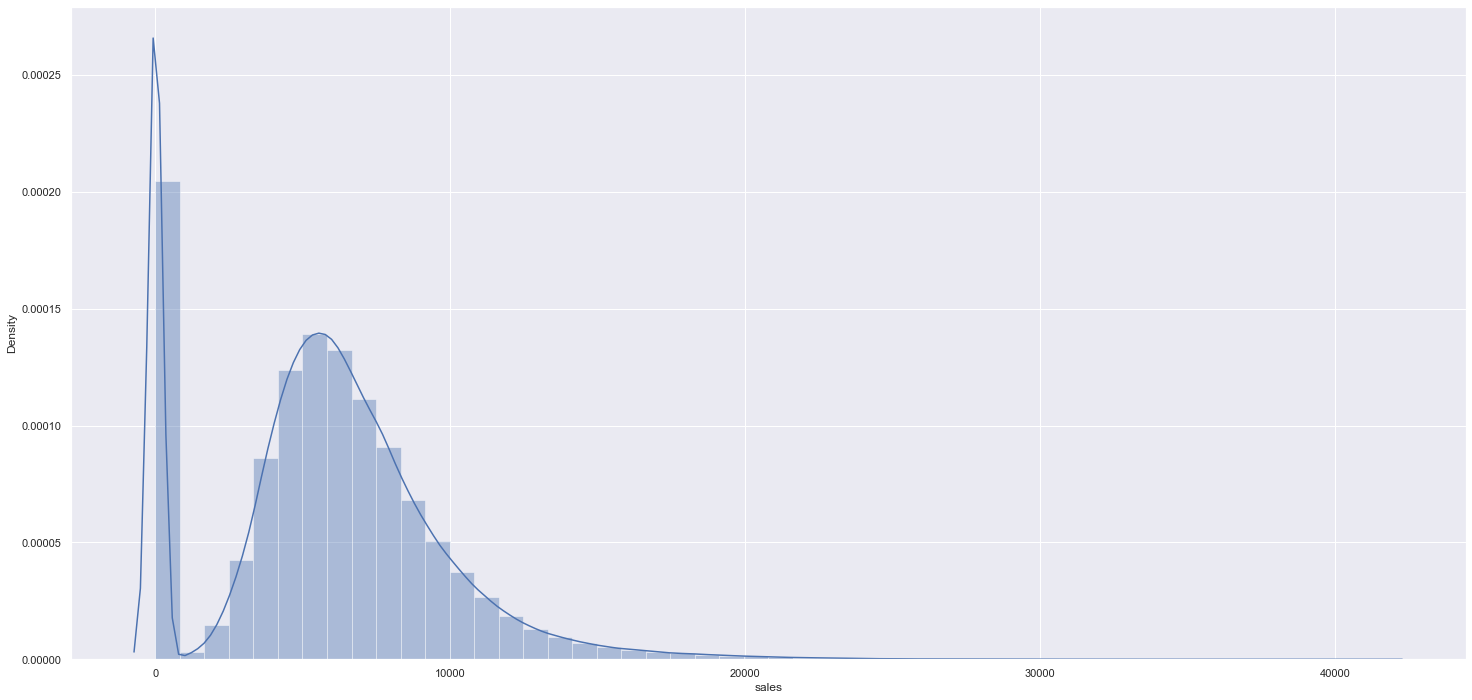

In [23]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

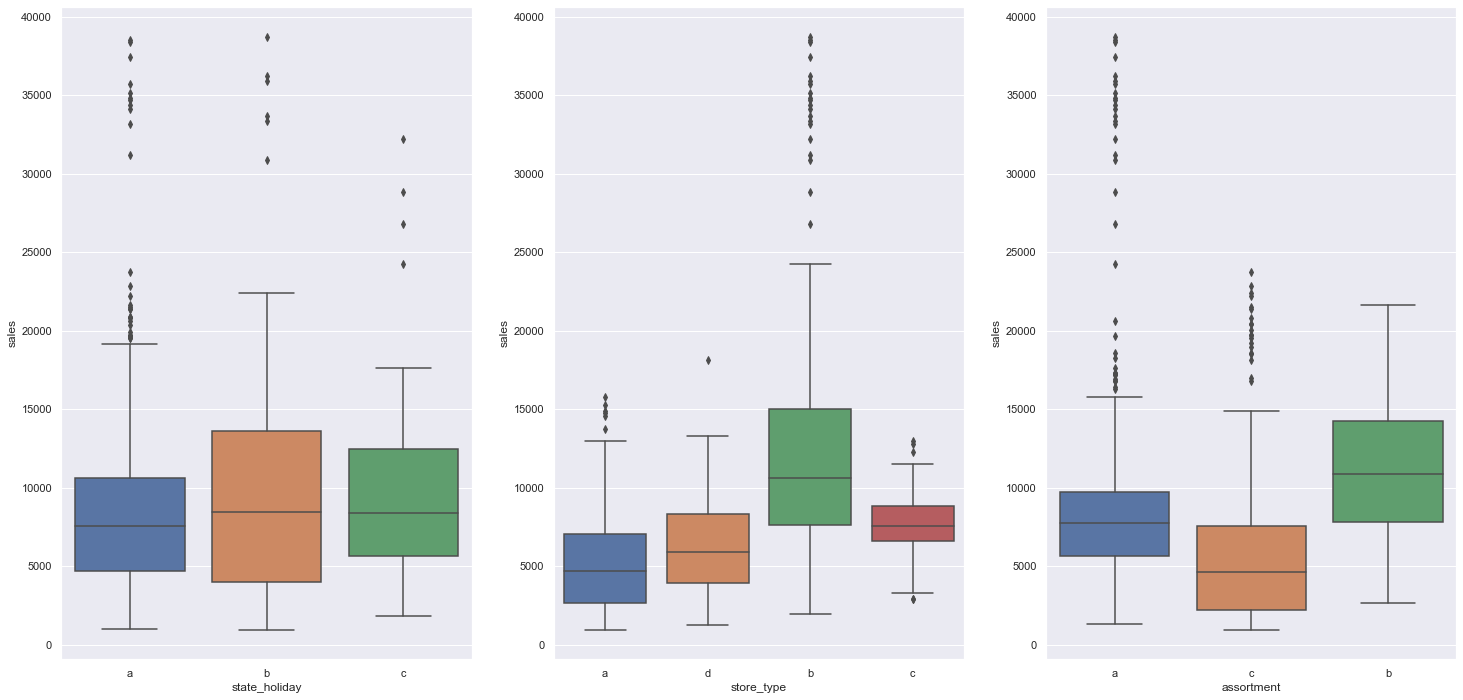

In [25]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0 PASSO 2: FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1 Criação de hipoteses

### 2.1.1 Mapa mental de hipóteses
- Fenômeno:
    * Qual fenômeno estou modelando?
- Agente:
    * Quem são os agentes que atuam sobre o fenômeno de interesse?
- Attributos do Agente:
    * Qual a descrição dos agentes?
- Lista de hipóteses
    * Hipóteses para validar os dados?
    * Gerar insight: 
        * Surpresa: descobre algo novo 
        * Contrapor uma crença: quebra uma ideia formada sobre algo


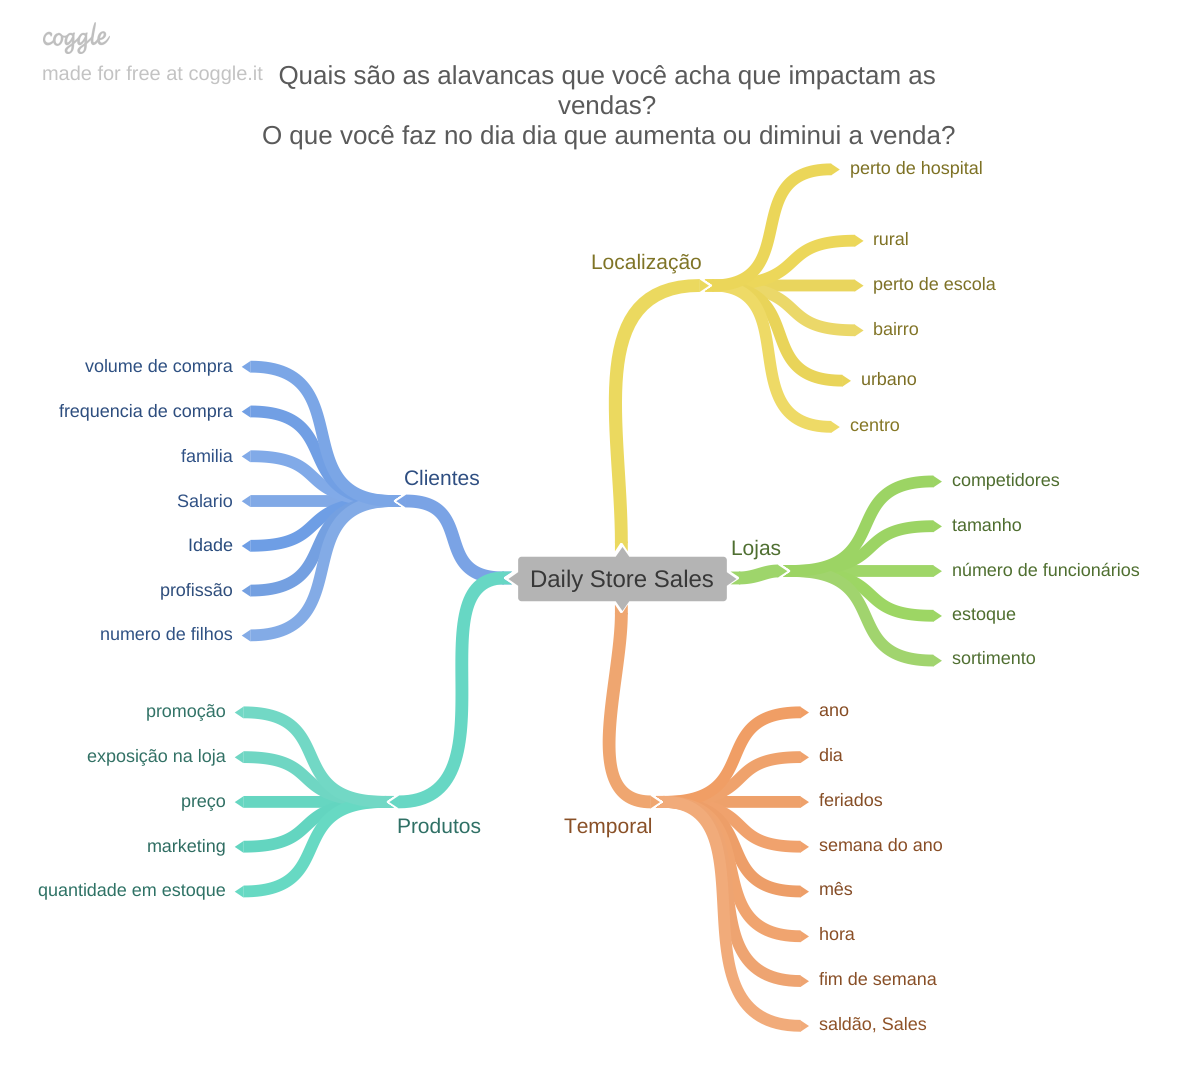

In [27]:
Image('img/MindMapHypothesis.png')

### 2.1.2 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.3 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem promoções mais agressivas(descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.4 Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** LOjas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de hipotese

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** LOjas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.



## 2.3 Feature Engineering

In [28]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime( 
        year=x['competition_open_since_year'], 
        month=x['competition_open_since_month'], 
        day=1 ), 
    axis=1)

df2['competition_time_month'] = ((df2['date'] -df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' 
    else 'easter_holiday' if x == 'b' 
    else 'christmas' if x == 'c' 
    else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 3: FILTRAGEM DE VARIÁVEIS

Filtragem de variáveis
* Restrições de negócio

Seleção de variáveis
* Variáveis mais relevantes para o MODELO


In [30]:
df3 = df2.copy()

In [31]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [32]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.2 Seleção das Colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
# axis 1 coluna, axis 0 linha
df3 = df3.drop(cols_drop, axis=1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 4 - ANALISE EXPLORATORIA DOS DADOS

* Como as variáveis impactam o fenômeno?
* Qual a força deste impacto?

Objetivos
1. Ganhar experiencia de negócio
2. Validar hipóteses de negócio (Insights)
3. Perceber variáveis que são importantes para o modelo

In [36]:
df4 = df3.copy()

## 4.1 Analise Univariada
- Como é essa variável?
    * (Min, Max, Distribuição, Range...)

### 4.1.1 Response variable

/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

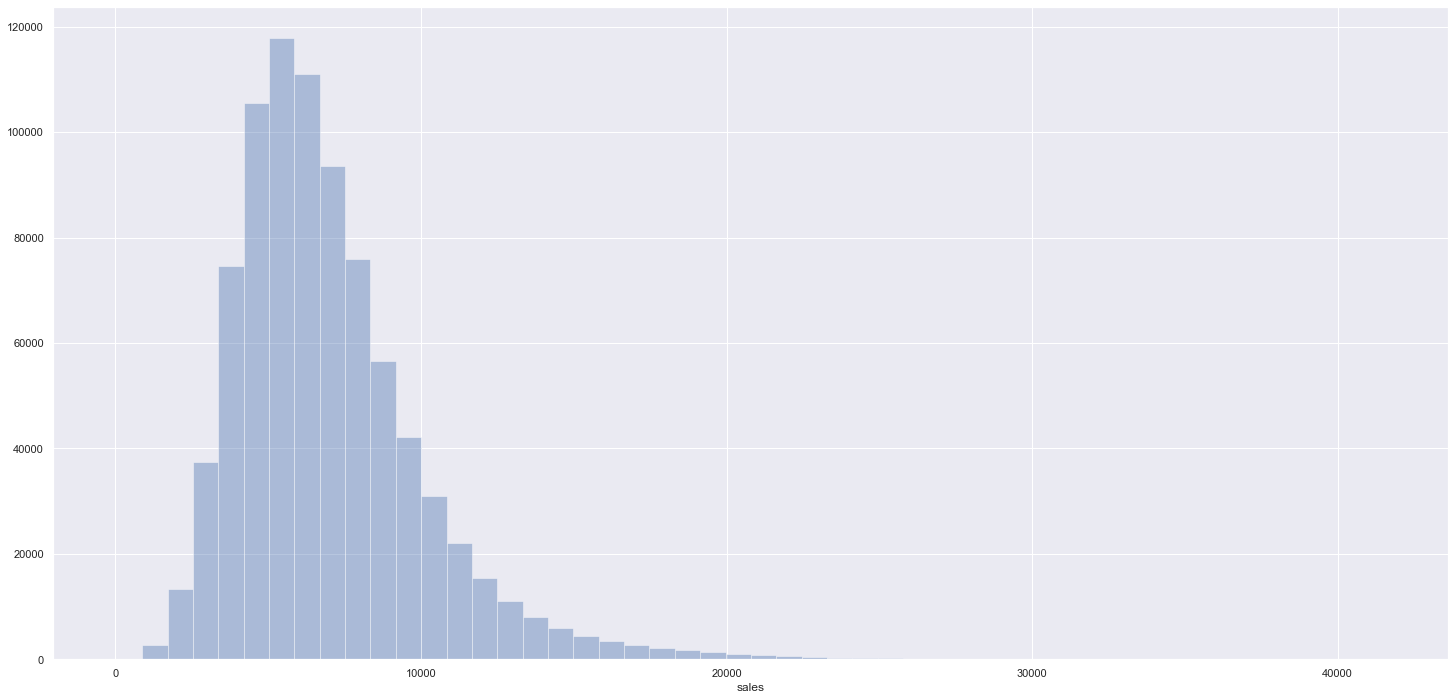

In [37]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Numerical variable

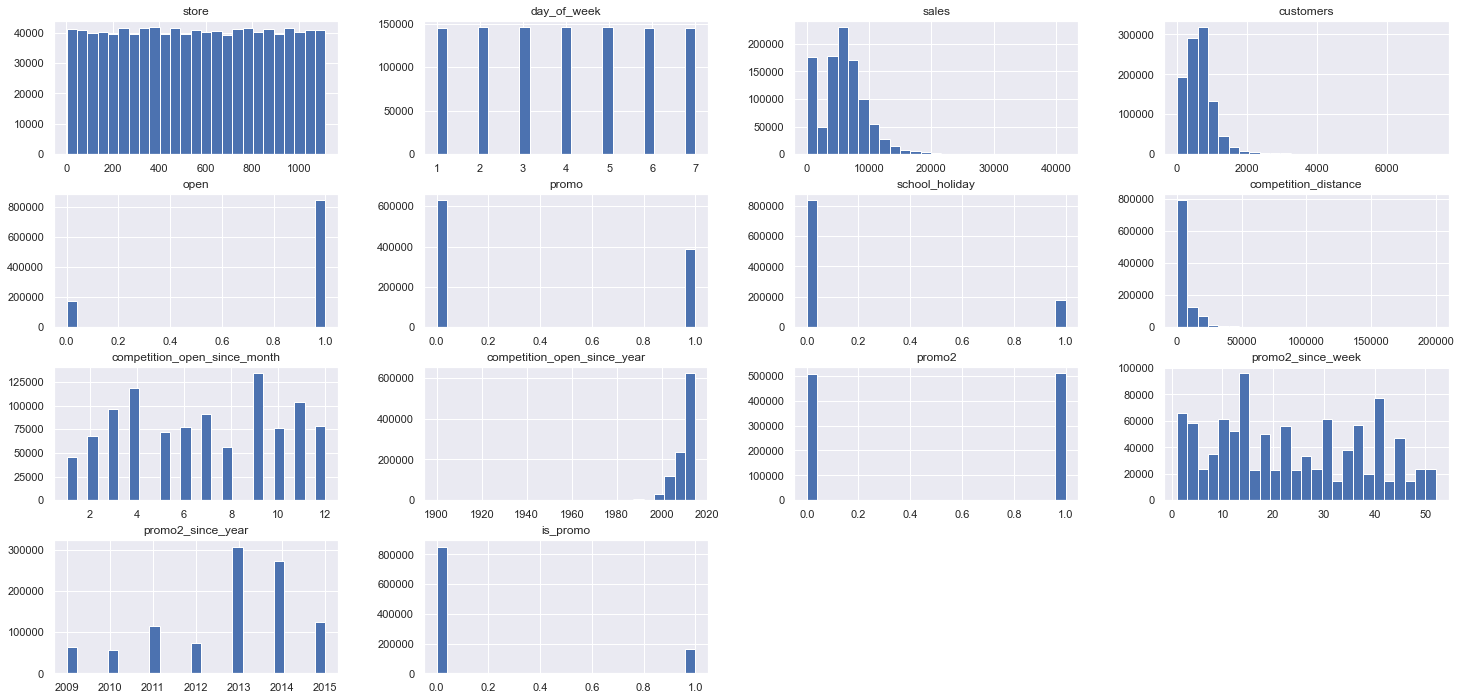

In [38]:
num_attributes.hist(bins=25);

- Customer
    * possui uma skew positiva o que significa que temos mais venda quando a quantidade de clientes na loja esta próximo a 30000

### 4.1.3 Categorical Variable

In [39]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [40]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument w

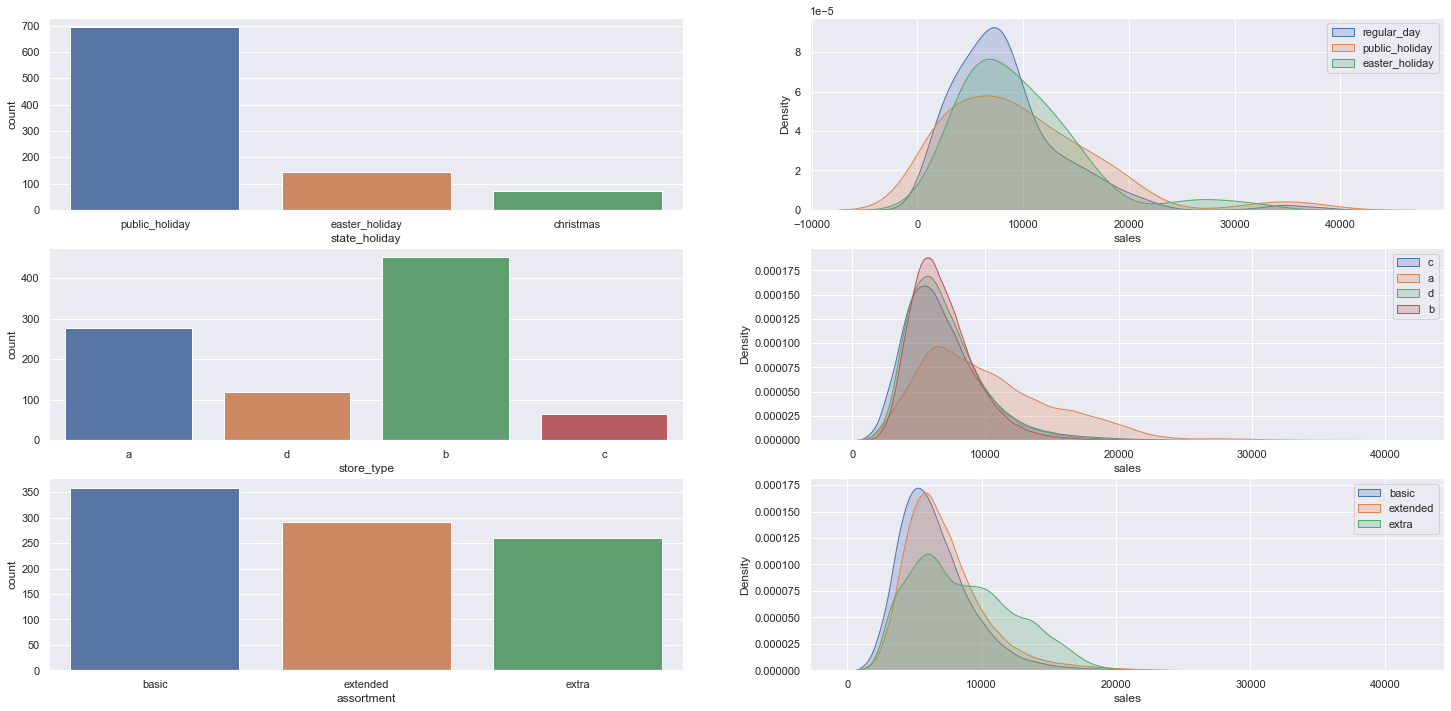

In [41]:
#state_holiday
plt.subplot(3, 2, 1)
holiday = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(holiday['state_holiday'])


plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend(df4['state_holiday'].drop_duplicates())
#store_type
plt.subplot(3, 2, 3)
sns.countplot(holiday['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend(df4['store_type'].drop_duplicates())
#assortment
plt.subplot(3, 2, 5)
sns.countplot(holiday['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend(df4['assortment'].drop_duplicates())

## 4.2 Analise Bivariada
- Como a variável impacta na resposta?
    * Correlação, Validação das hipóteses

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA**: Lojas com MAIOR SORTIMENTO vendem MENOS.

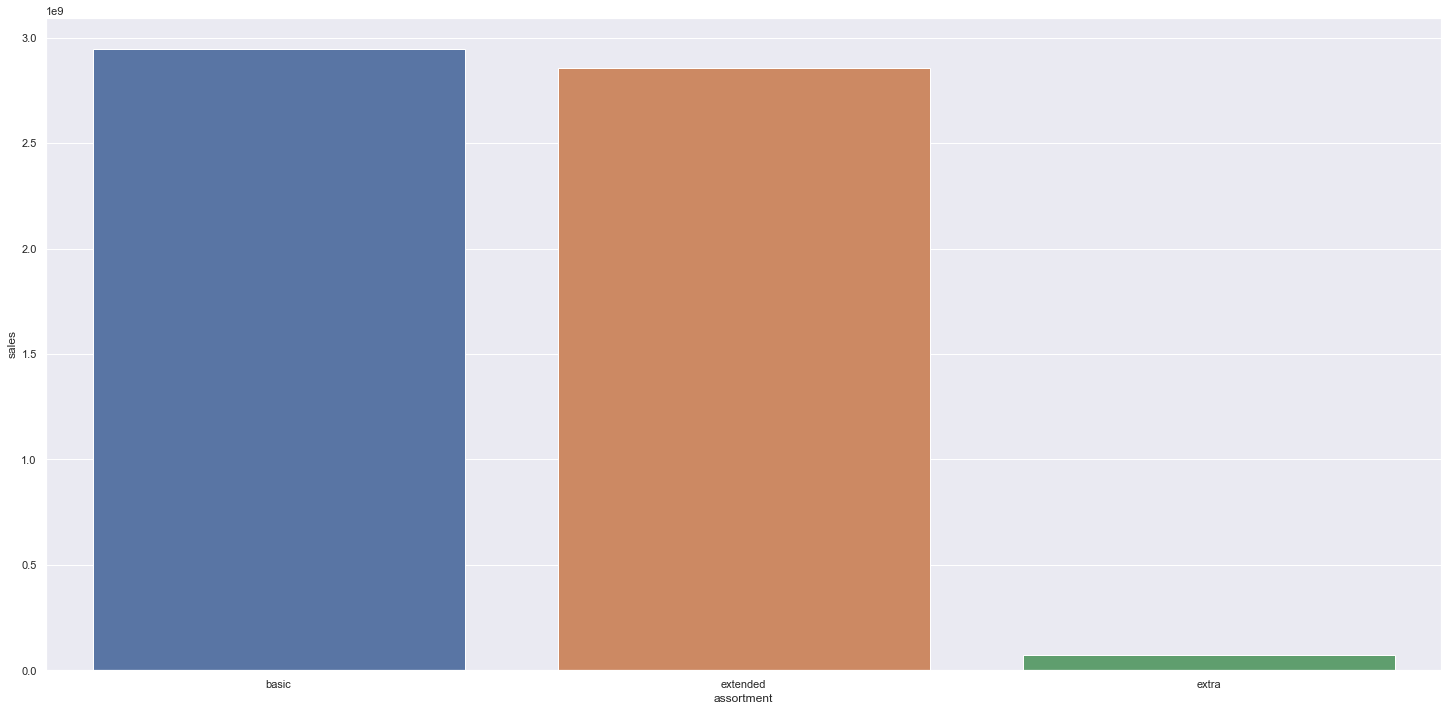

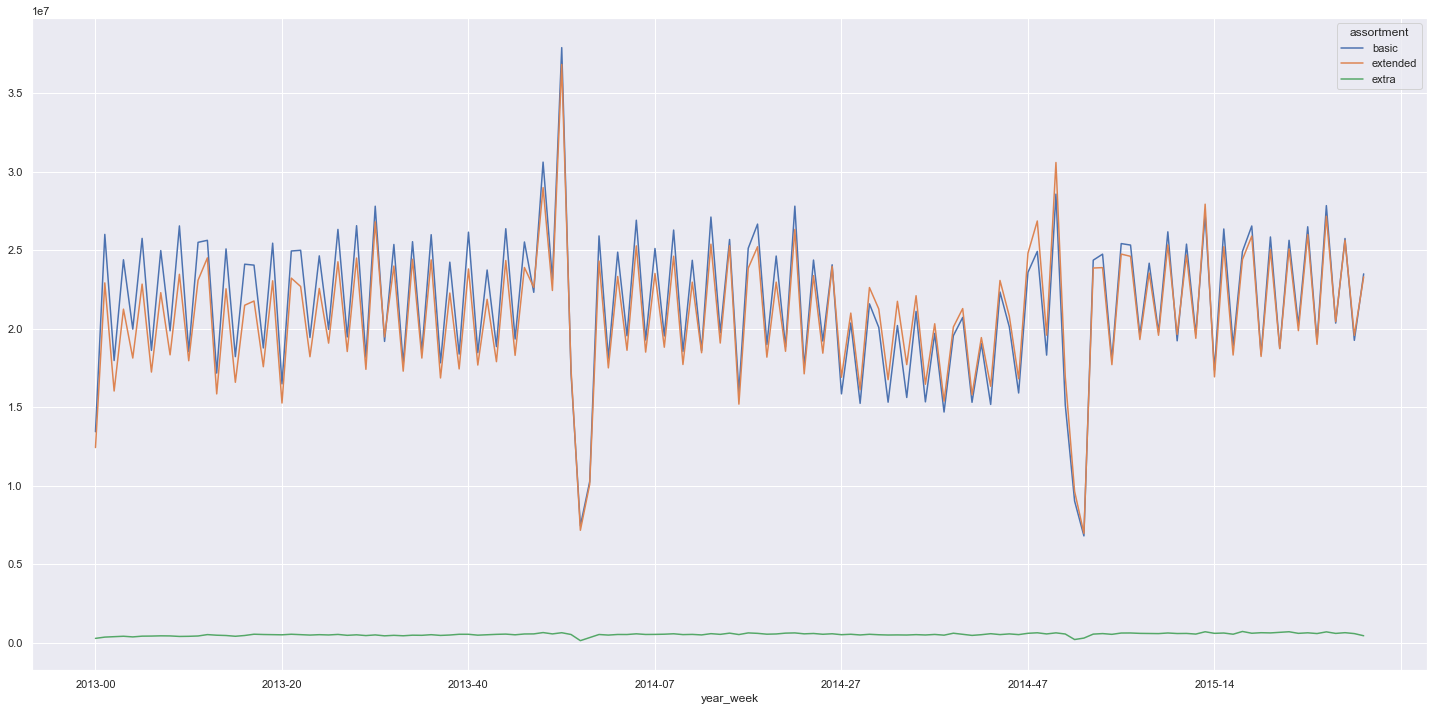

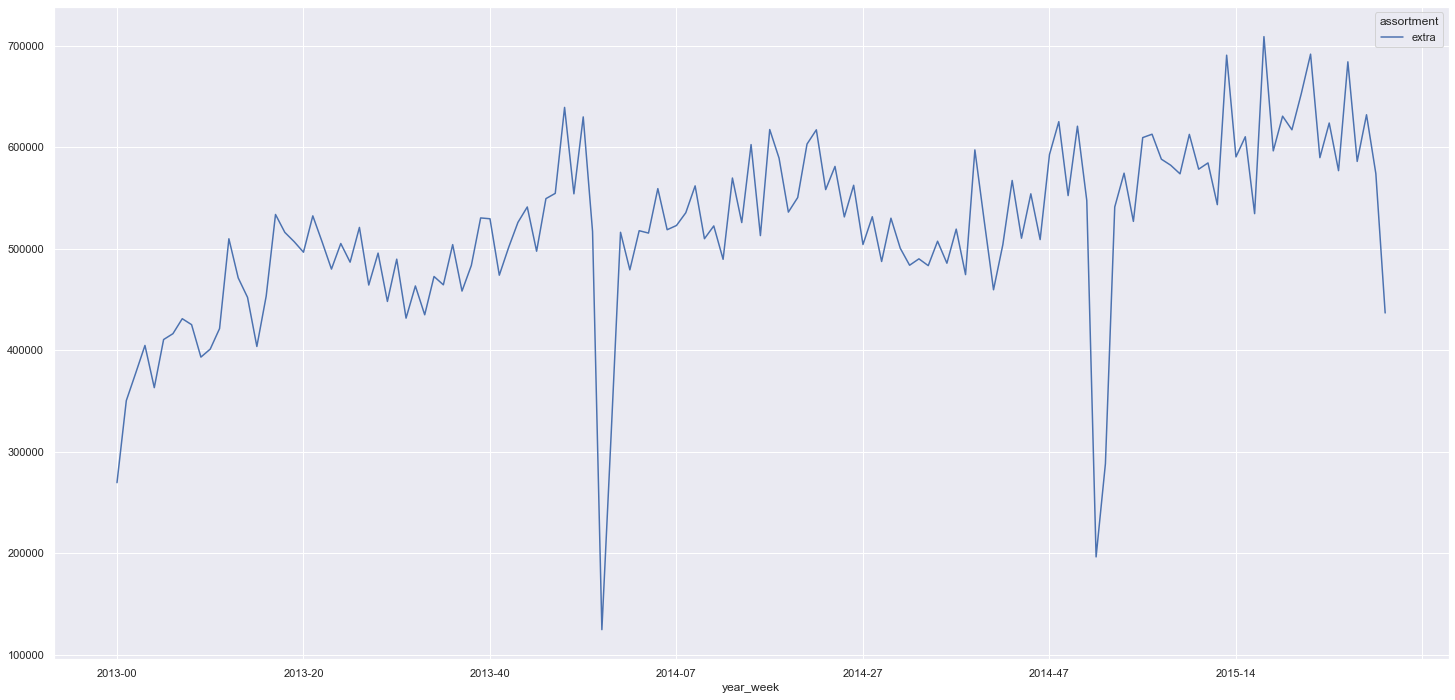

In [42]:
sales_by_assortment = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=sales_by_assortment)

sales_by_assortment_and_year_week = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
sales_by_assortment_and_year_week.pivot(index='year_week', columns='assortment', values='sales').plot()

extra_sales_by_assortment_and_year_week = sales_by_assortment_and_year_week[sales_by_assortment_and_year_week['assortment'] == 'extra']
extra_sales_by_assortment_and_year_week.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

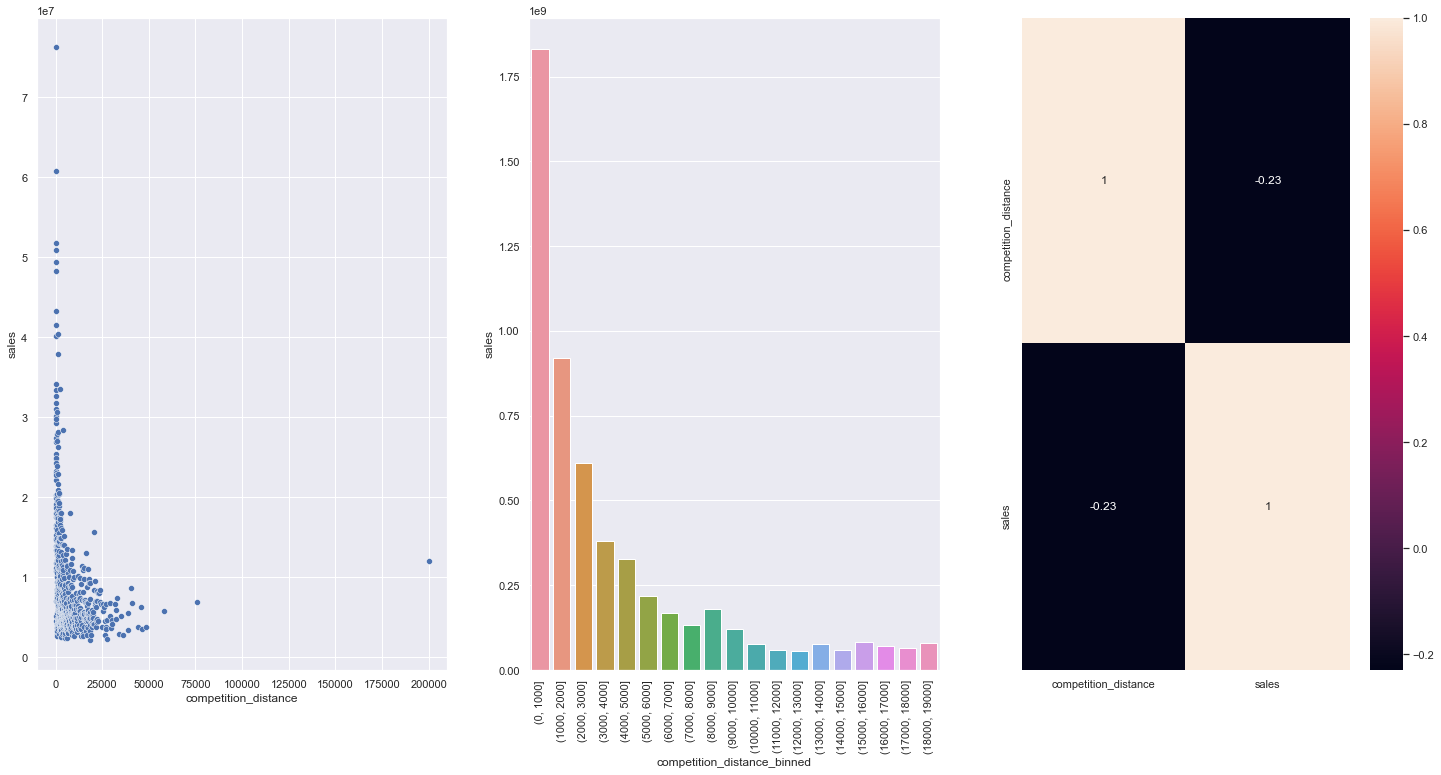

In [43]:
aux1 =df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H3.** Lojas com competidores a mais tempo deveriam vender mais 

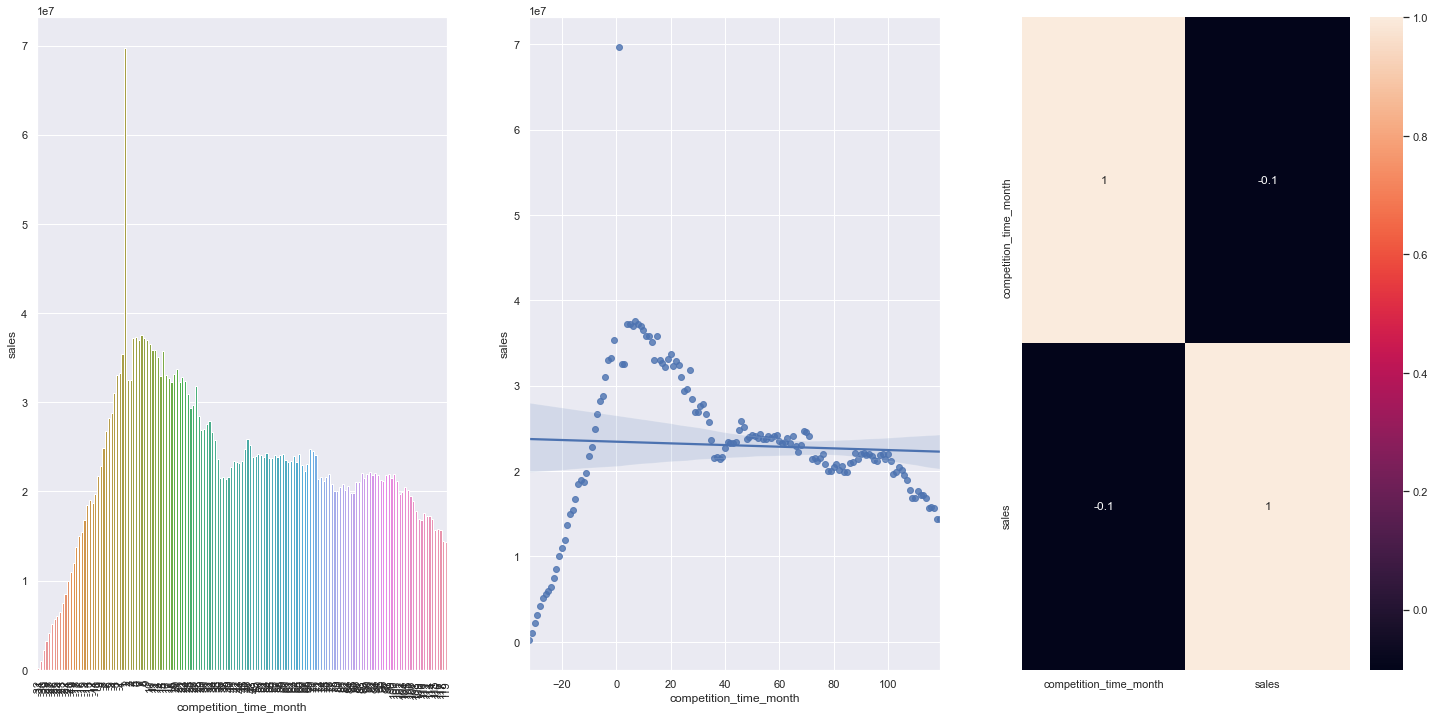

In [44]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoções ativas por mais tempo, VENDEM MENOS depois de um certo periodo de promoção.

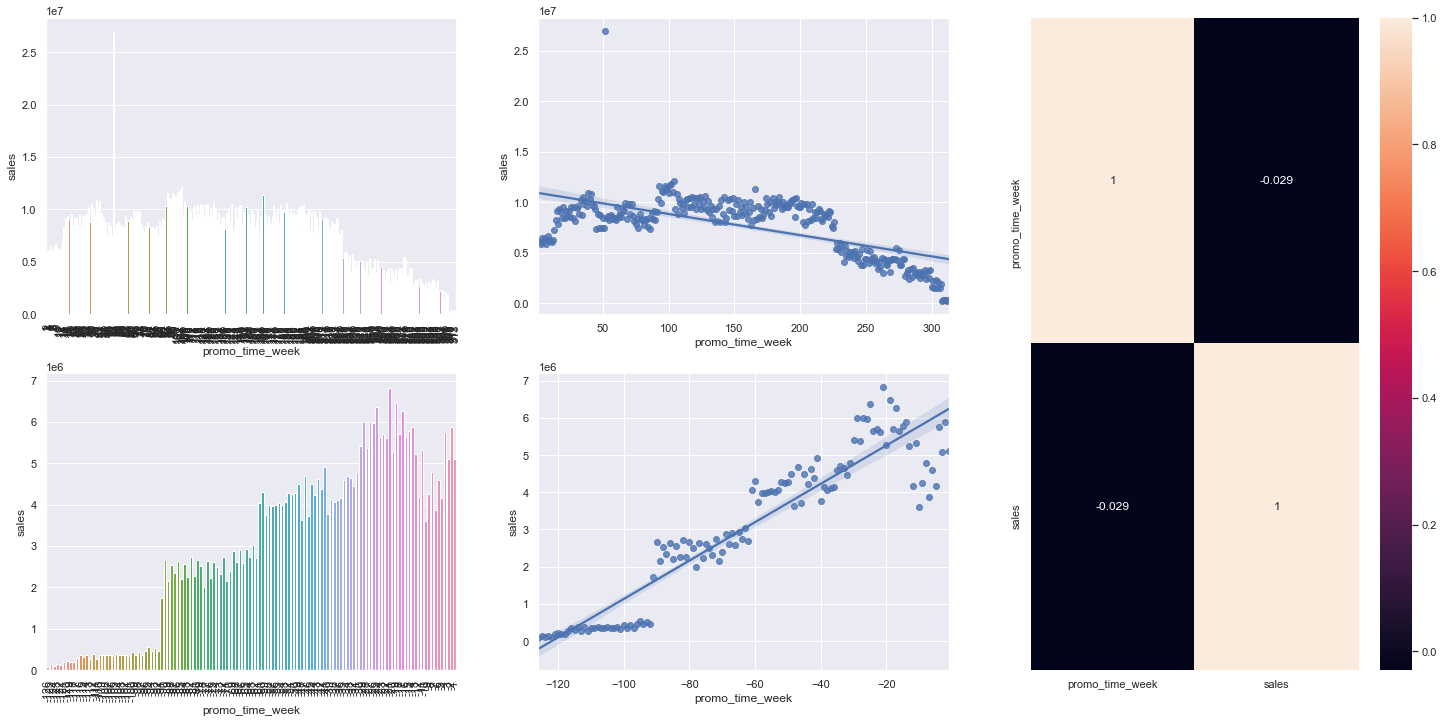

In [45]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index() 

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),  annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** Lojas com promoções consecutivas vendem menos

In [46]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


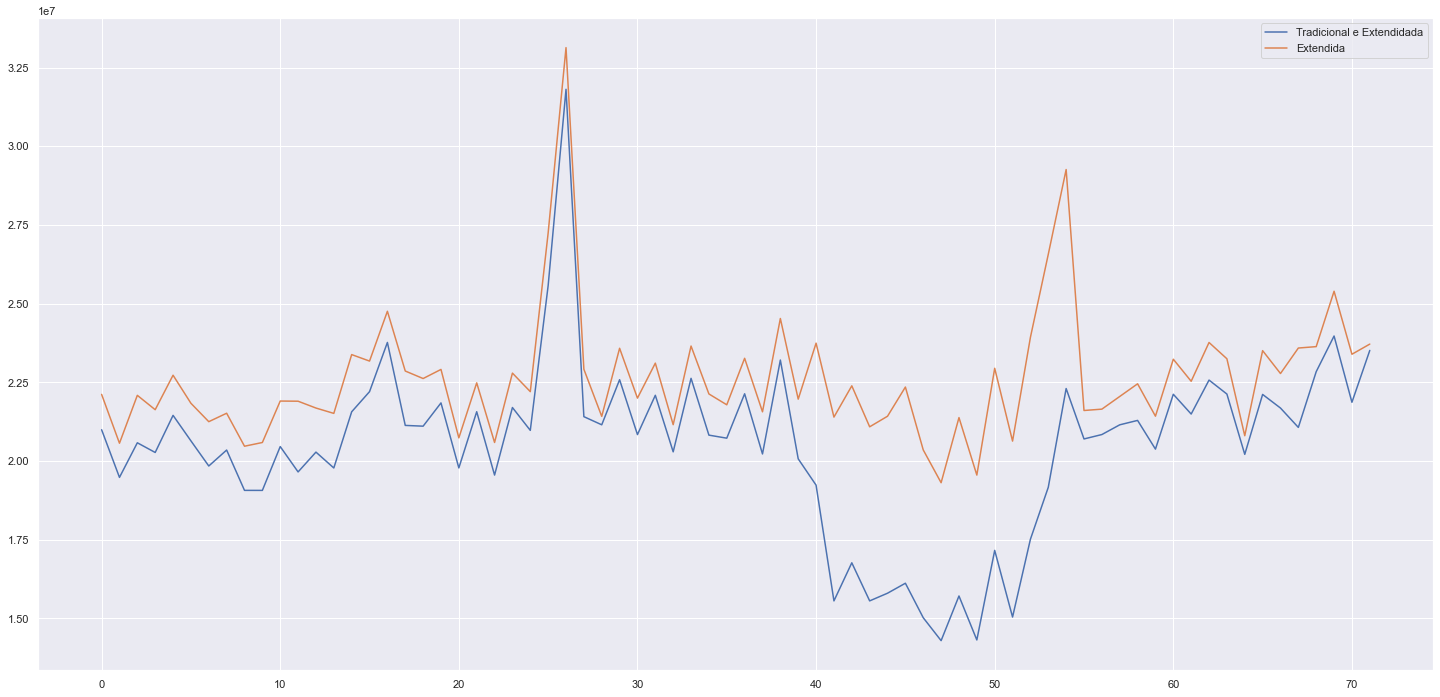

In [47]:
aux1 = df4[( df4['promo'] ==1 ) & ( df4['promo2']==1) ][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux1 = df4[( df4['promo'] ==1 ) & ( df4['promo2']==0) ][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendidada', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
*FALSO* Lojas abertas durante o feriado de NATAL vendem MENOS

<AxesSubplot:xlabel='year', ylabel='sales'>

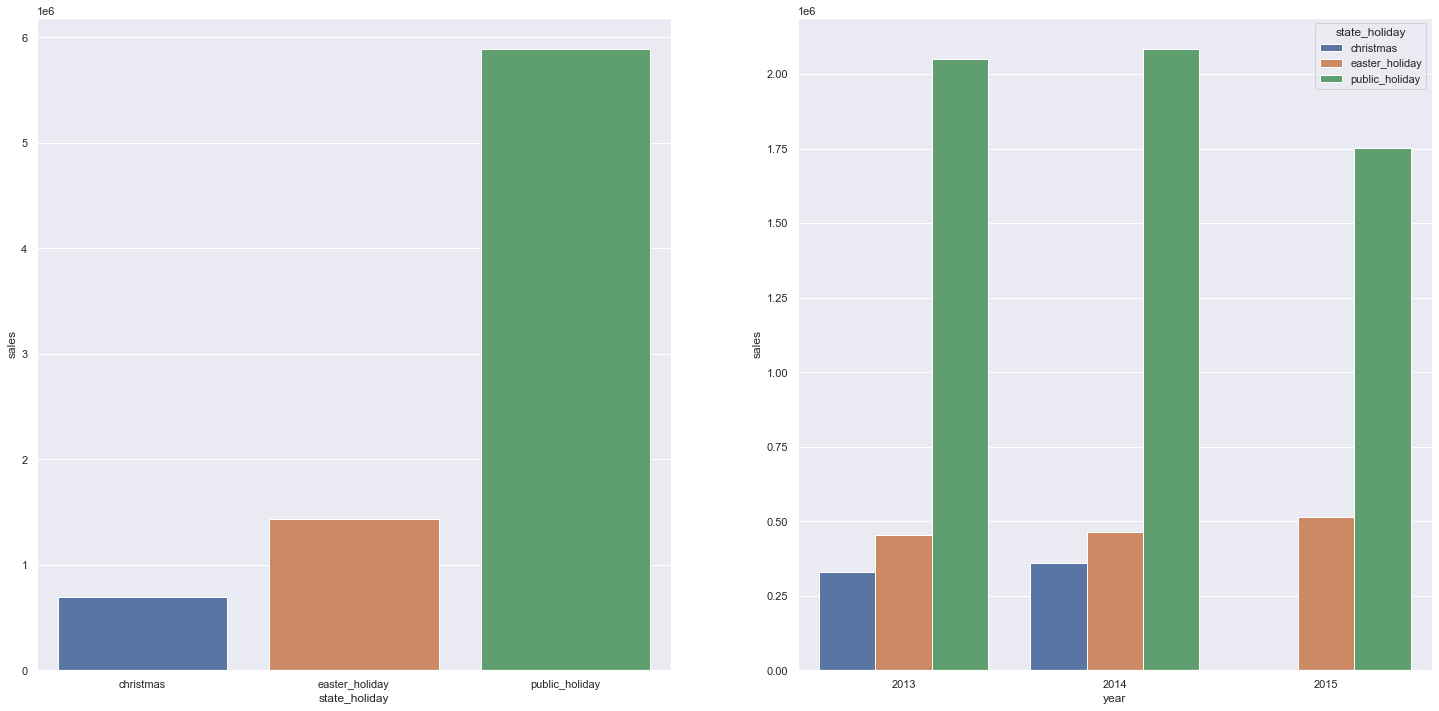

In [48]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y="sales", data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### **H8.** Lojas deveriam vender mais ao longo dos anos.
*FALSO* Lojas vendem MENOS ao longo dos anos

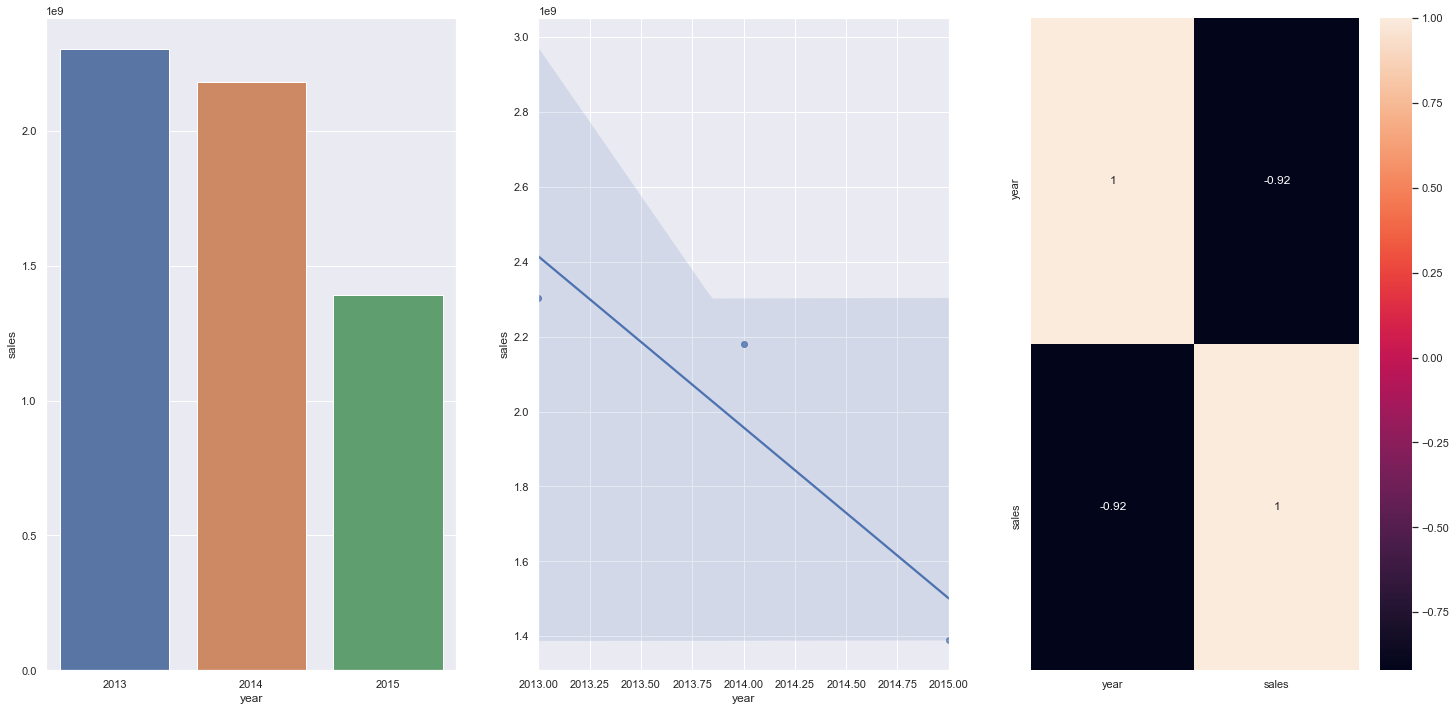

In [49]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
*FALSO* Lojas vendem menos no segundo semestre do ano

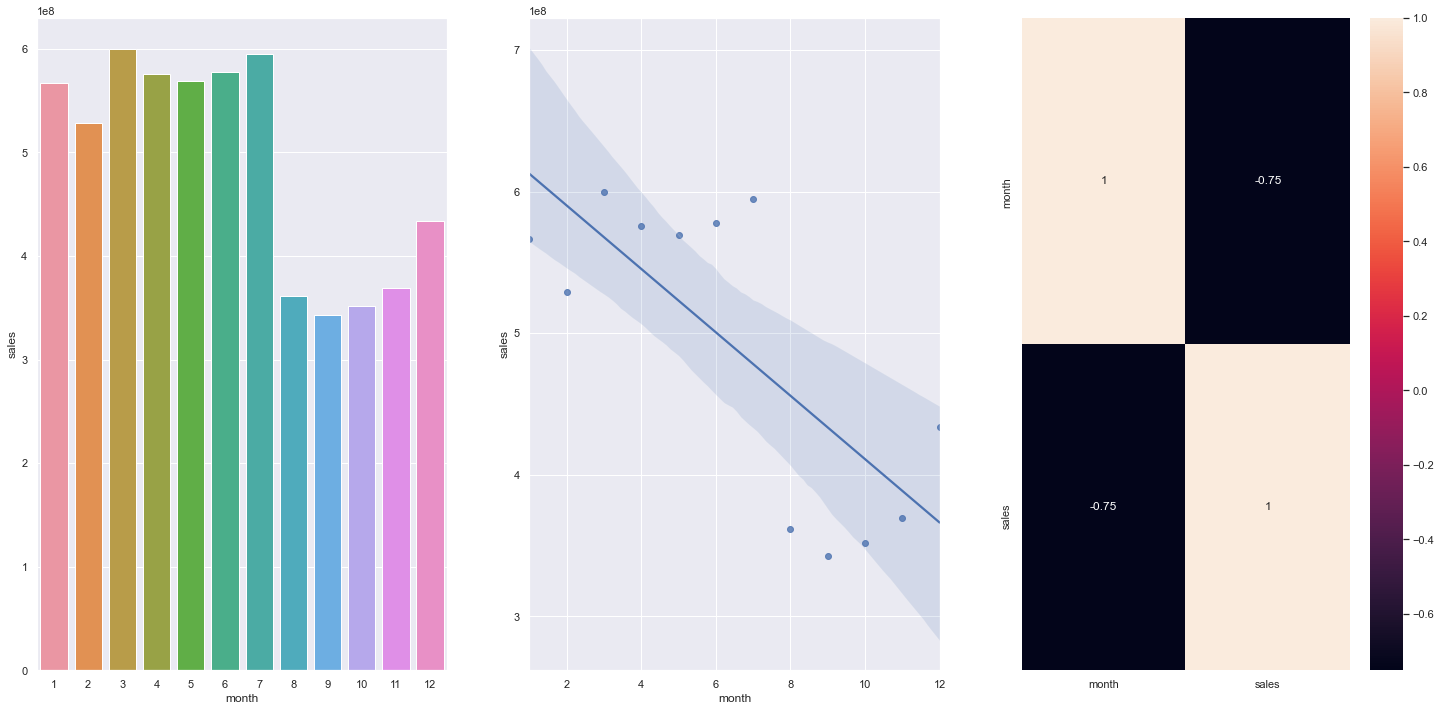

In [50]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
*VERDADEIRA* Lojas vendem mais após o dia 10 de cada mês

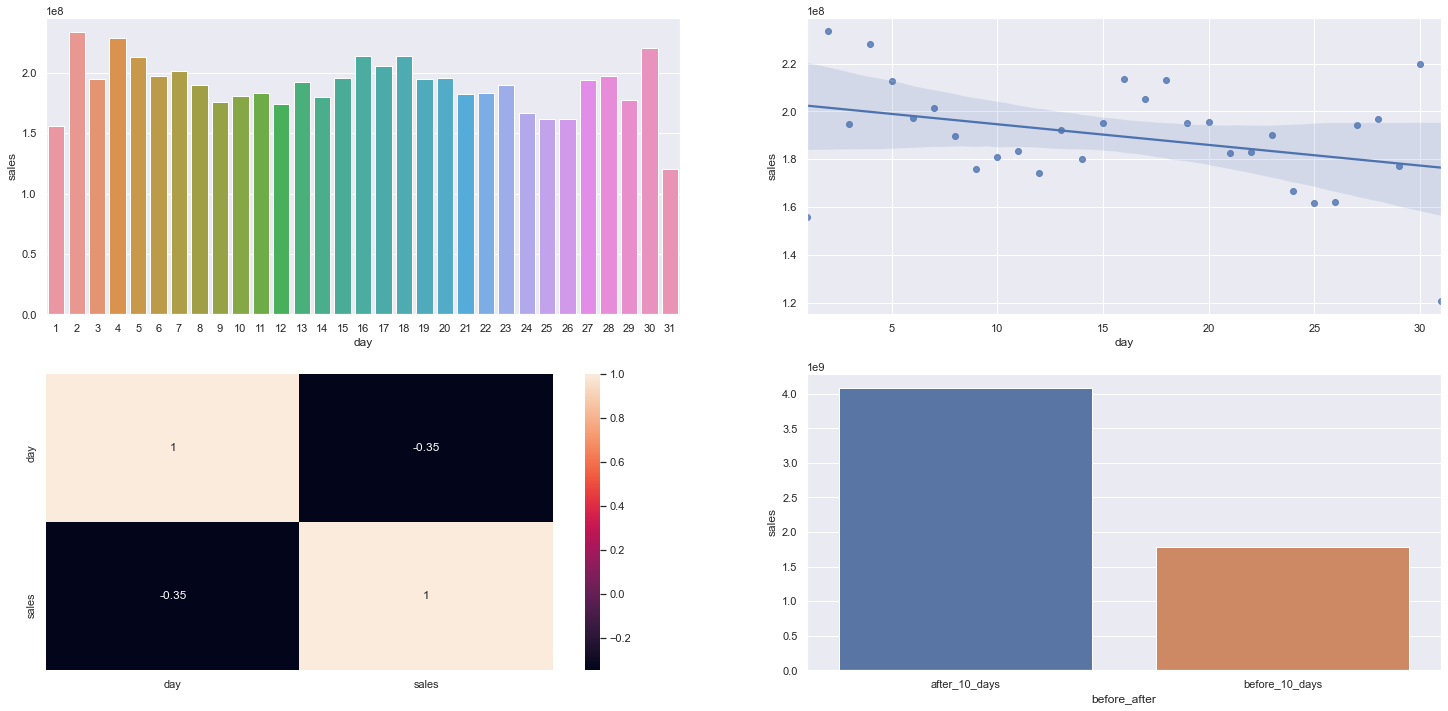

In [51]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
*VERDADEIRA* Lojas vendem menos aos finais de semana

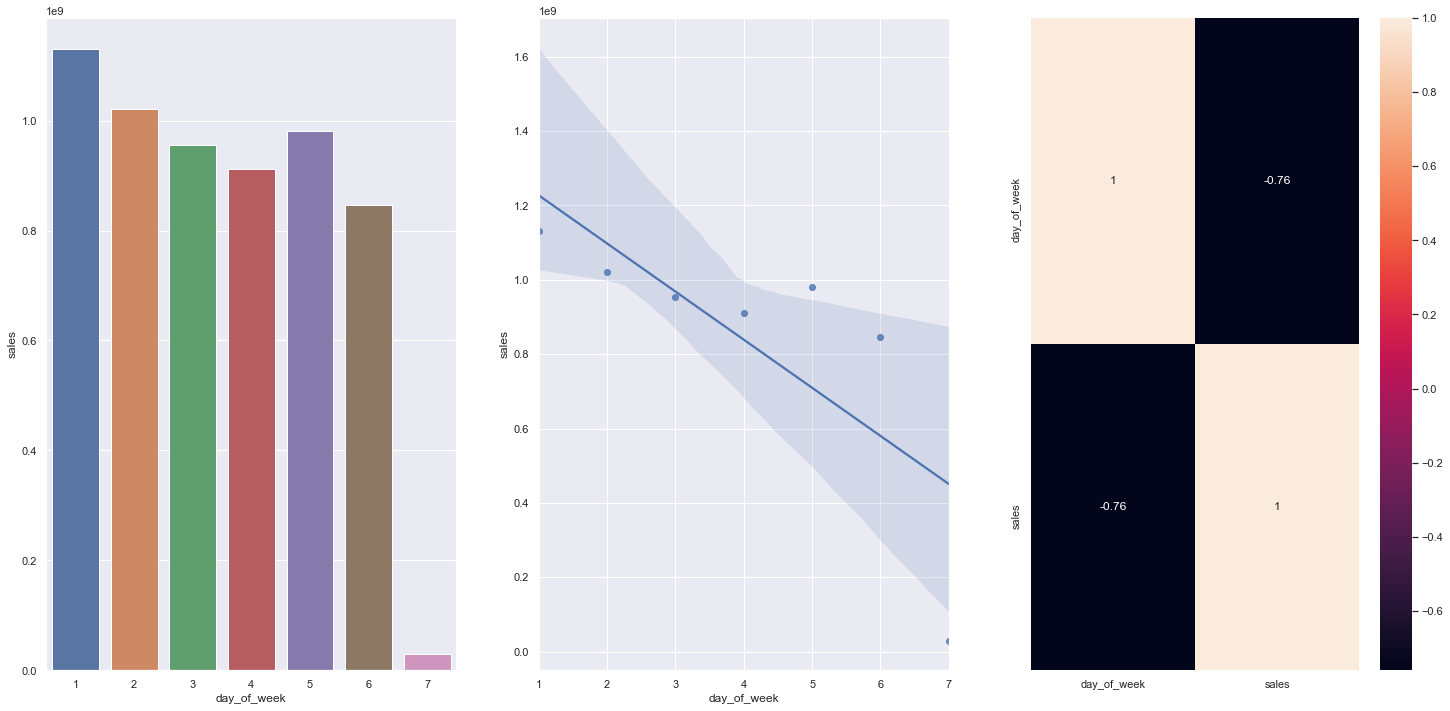

In [52]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### *H12.* Lojas deveriam vender menos durante os feriados escolares.
*VERDADEIRA* Lojas VENDEM MENOS durante os feriados escolares EXCETO os meses de JULHO e AGOSTO

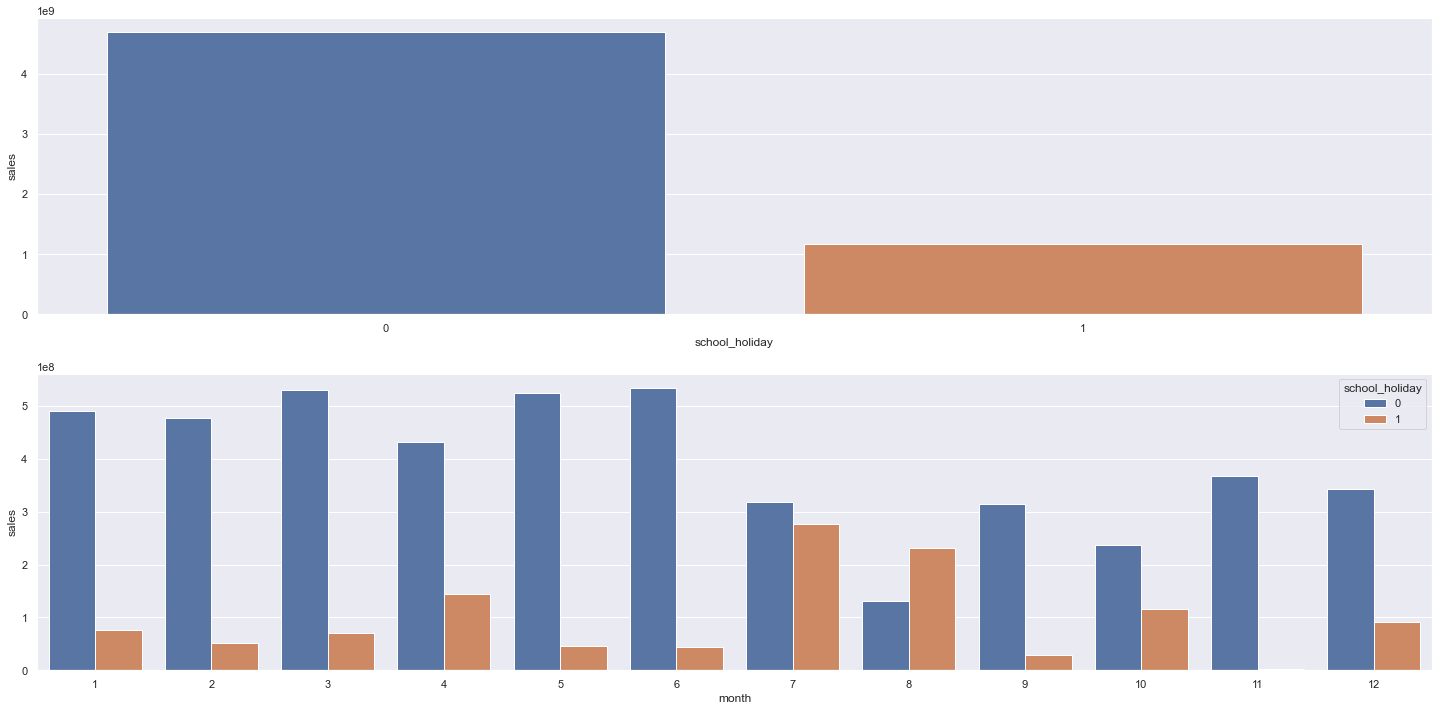

In [53]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1);
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2);
sns.barplot(hue='school_holiday', x='month', y='sales', data=aux2);


### 4.2.1 Resumo de hipoteses

In [54]:
tab = [['Hipotese', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Média'],
        ['H3', 'Falsa', 'Média'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Média'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa']]
print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Analise Multivariada
- Como as variáveis se relacionam?
    * Qual a correlação entre elas?

### 4.3.1 Numerical Attributes

<AxesSubplot:>

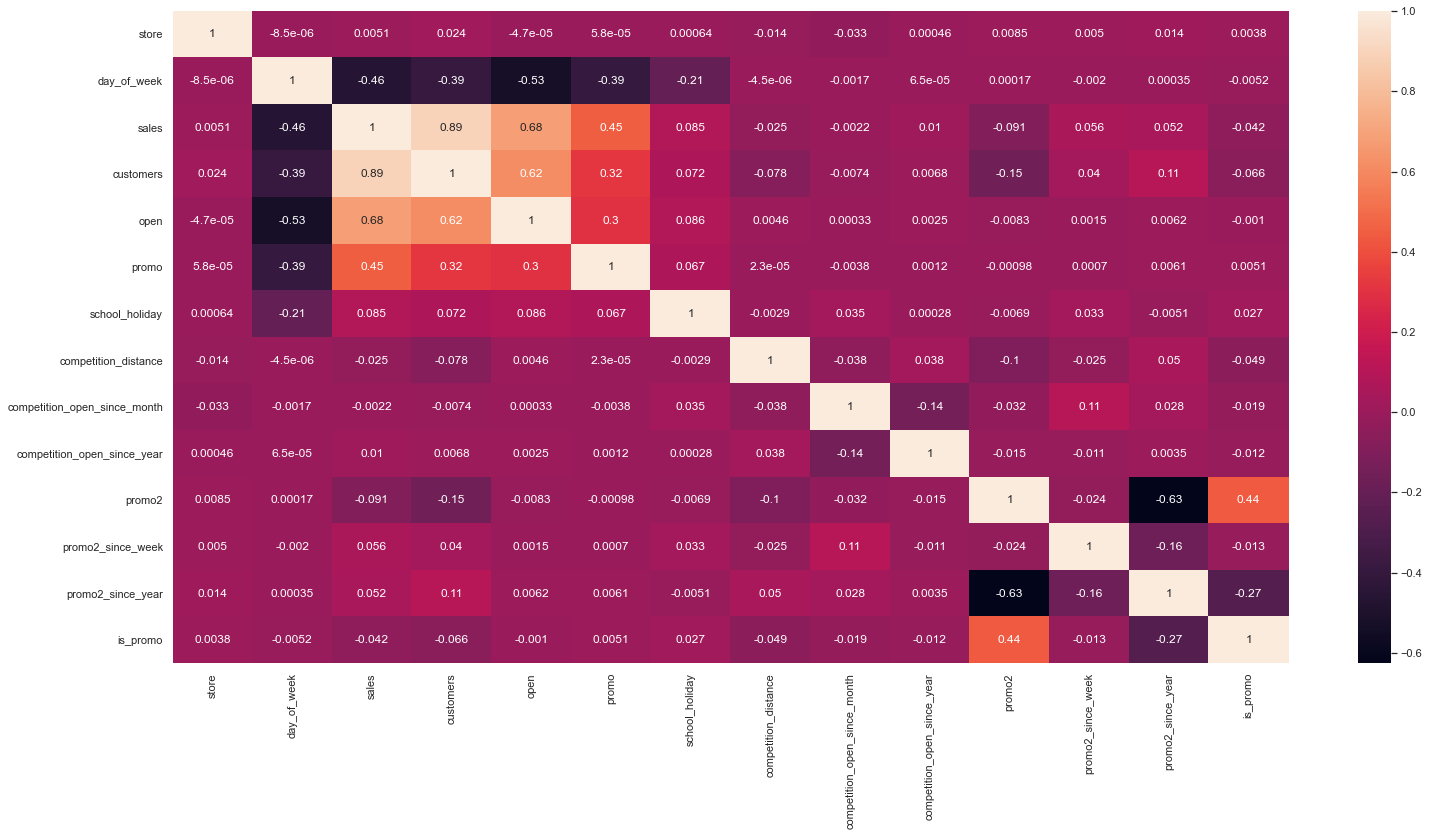

In [55]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

<AxesSubplot:>

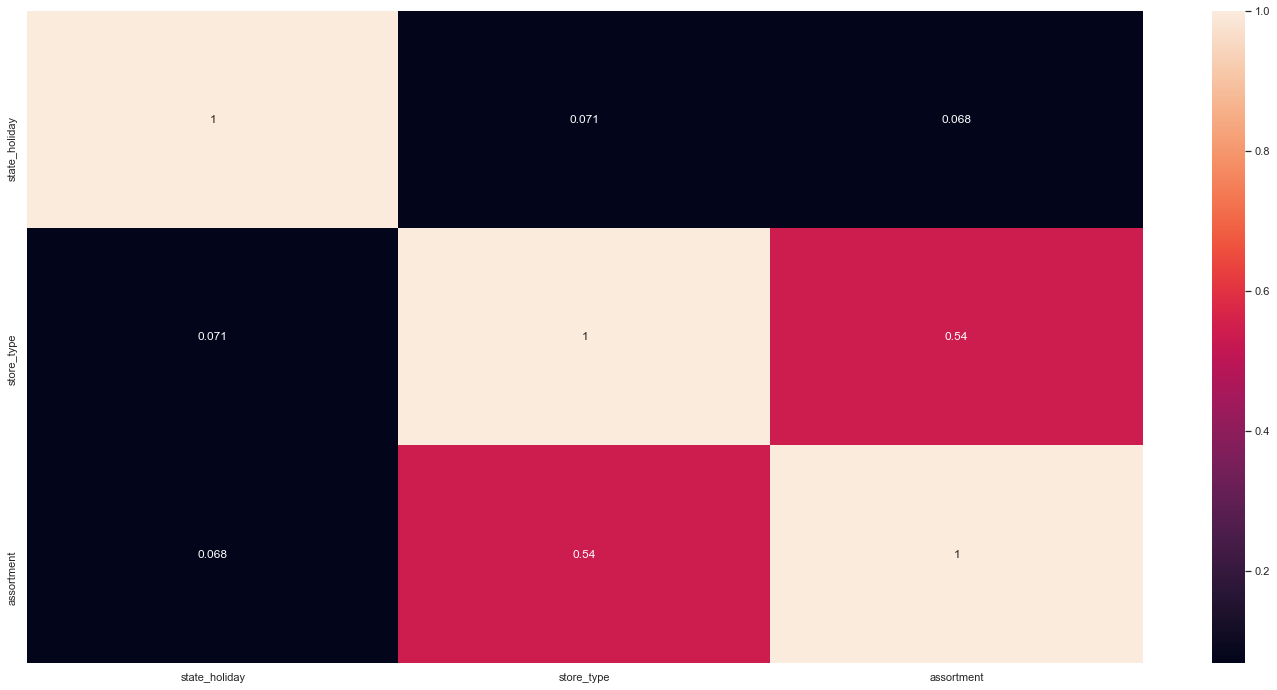

In [56]:
# Oly categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 PASSO 5 - DATA PREPARATION

## Tipode de preparação

* Normalização
** Colocar todos os dados em mesma escala numerica
** Reescala o centro para 0 com desvio-padrão igual a 1

* Rescaling 
** Reescala para o intervalo entre 0 e 1
** Distribuição não Gaussianas( não normal )

* Transformação 
** Conversão de features categoricas para numéricas (Encofing)
** Transformação de natureza

In [57]:
df5 = df4.copy()

## 5.1 Normalização

In [58]:
# Não ha variaveis com distribuição normal nos dados

## 5.2 Rescaling

In [59]:
#filtrando somente numericos
# a.dtypes
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


In [60]:
rs = RobustScaler()
mms = MinMaxScaler()

# visualização da variavel para perceber a existencia de outliers
#sns.boxplot(data=df5['year'], orient="v");

# Variavel com Outliers - RobustScaler
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# Variavel sem Outliers - MinMaxScaler
#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

Transformação
* Grandeza: tenta trazer os dados para uma distribuição proxima a normal, para ter um melhor match com o algoritmo que é baseado na normal
* Natureza: pretende prezervar o ciclo, como em meses onde mes 1 é proximo ao 2 mas distante de 12. porem 12 é proximo a 1 na virada de ano.

Tipos de transformação
1. Logarithm Transformation
2. Box-Cox Transformation
3. Cube-Root Transformation
4. Square-Root Transformation
5. Sine and Cosine Transformation

### 5.3.1 Encoding

In [61]:
#state_holiday - One Hot Encoding
#ha momentos em que o statudo muda, neste caso o momento muda de acordo com o estado do feriado
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
#Não tem uma ordem definida, nem relação entre as categorias
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
#Existe relação entre as categorias basic, extended, extra
#df5['assortment'].drop_duplicates()

assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [62]:
sales_before_transformation = df5['sales']

In [63]:
df5['sales'] = np.log1p(df5['sales'])

/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sales log transformation')

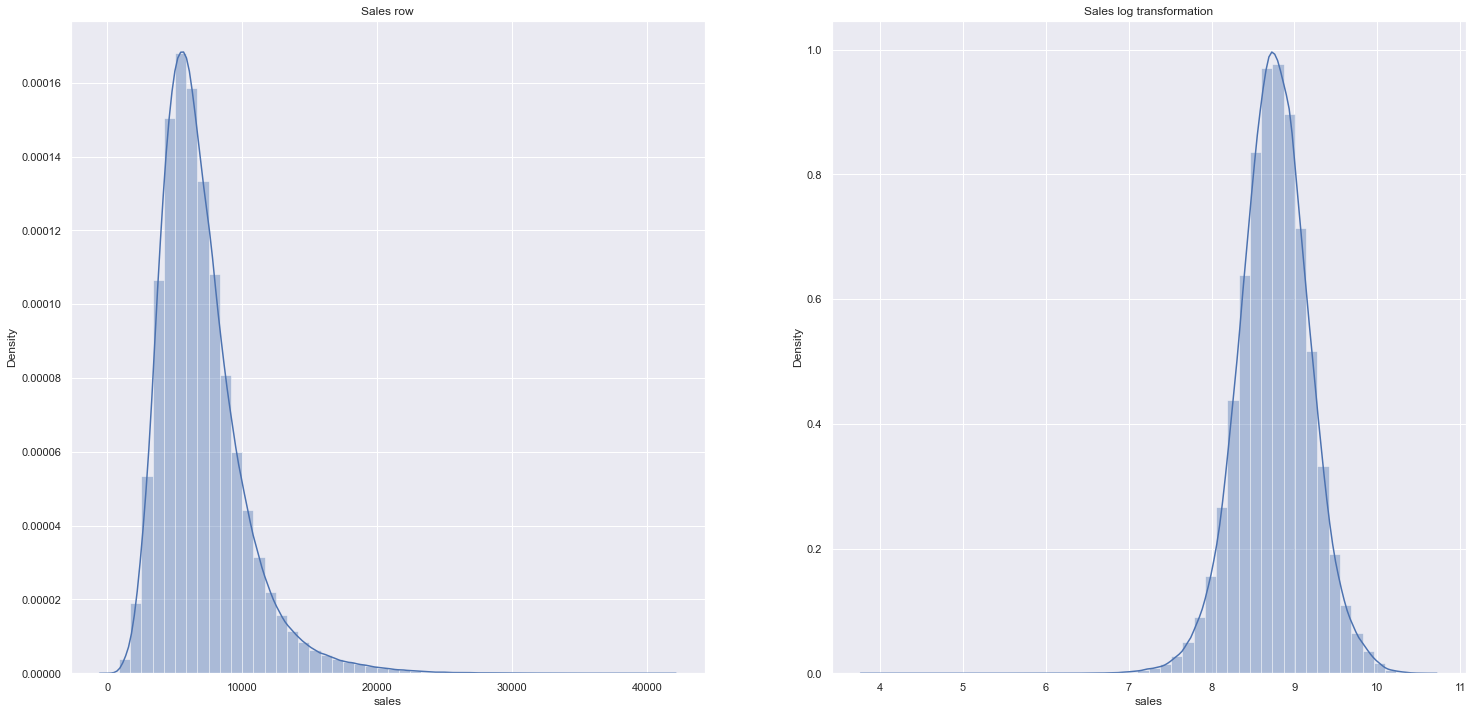

In [64]:
plt.subplot(1,2,1)
sns.distplot(sales_before_transformation);
plt.title("Sales row")

plt.subplot(1,2,2)
sns.distplot(df5['sales']);
plt.title("Sales log transformation")

### 5.3.3 Nature Transformation

In [65]:
#day_of_week - cicle 7 days
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

#month - cicle 12 month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

#day - cicle 30 days
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#week_of_year - cicle 52 weeks
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 Passo 6 - Feature Selection

Feature selection ou seleção de variaveis determina a escolha das variáveis que são **relevantes** e farão parte do modelo em busca da generalização.

O objetivo é remover do conjunto de dados as variáveis colineares (aquelas variaveis que explicam a mesma parte do fenômeno), tornando o conjunto de dados mais simples para definir um modelo também mais simples. 

## Tipos de seleção

### 1. Seleção univariada - Filter Methods

####  Quadro Resumos 
<table>
  <tr>
    <th>Variável Preditora</th>
    <th></th>  
    <th>Variável Resposta</th>
    </tr>
  <tr>
    <th>Contínua</th>
    <td>Correlação de pearson</td>
    <td>Linear Discimonant Analysis (LDA)</td>
  </tr>
  <tr>
    <th>Categórica</th>
    <td>Anova</td>
    <td>Chi-Square/ Crammer-V</td>
  </tr>
</table>

#### Vantagens
1. Método Simples
2. Método Rápido
3. Fácil Entendimento

#### Desvantagens
1. Não considera a influência dentre variáveis
* Sozinha tem fraca correlação para explicar o fenomeno, mas se combinada com outra variável poderia ter forte correlação

### 2. Seleção de importância - Embedded Methods
* Embedded por que podemos usar a capacidade embutida no algoritmo para seleção de variáveis de maior importância determinada pelo algoritmo

1. Random Forest
2. Lasso Regression
3. Ridge Regression

### 3. Seleção por SubSet - Wrapper Methods


In [66]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [67]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [68]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [69]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [70]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# Y_train_n = Y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# #define boruta
# boruta = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=2).fit(X_train_n, Y_train_n)

### 6.2.3 Best Features from Boruta

In [71]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# # iloc index - todas as colunas e linhas que estão no cols_selected]
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.3 Manual Feature Selection

In [72]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [73]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [140]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Avarage Model

In [75]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [76]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.1 Linear Regression Model - Cross Validation

In [146]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)

In [142]:
lr_result_cv

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model

In [77]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## 7.3.1 Linear Regression Regularized Model - Cross Validation

In [144]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lrr)

In [145]:
lrr_result_cv

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest

In [78]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.115257,0.099842,1010.322344


## 7.4.1 Random Forest - Cross Validation

In [147]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, True)

Kfold number 5
Kfold number 4
Kfold number 3
Kfold number 2
Kfold number 1


In [148]:
rf_result_cv

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Random Forest,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61


## 7.5 XGBoost Regressor

In [79]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.759417,0.949487,7331.077162


## 7.5.1 XGBoost Regressor - Cross Validation

In [151]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, True)

Kfold number 5
Kfold number 4
Kfold number 3
Kfold number 2
Kfold number 1


In [152]:
xgb_result_cv

,MODEL,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7048.93 +/- 588.52,0.95 +/- 0.0,7714.89 +/- 689.29


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [80]:
modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.115257,0.099842,1010.322344
0,Avarage Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.759417,0.949487,7331.077162


### 7.6.2 Real Performance - Cross Validation

In [159]:
modeling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv.sort_values('RMSE CV')

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Random Forest,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7048.93 +/- 588.52,0.95 +/- 0.0,7714.89 +/- 689.29
